In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
%matplotlib inline
#%config InlineBackend.figure_format = 'svg' 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import pickle as pkl
import dtreeviz
import imodelsx.process_results
from sklearn.tree import plot_tree
import sys
import numpy as np
import viz
# import llm_tree.data
import imodelsx
import sklearn.tree
sys.path.append('../experiments/')

/home/jxm3/.conda/envs/torch/lib/python3.10/site-packages/langchain/vectorstores/analyticdb.py:20: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)


In [3]:
# results_dir = '/home/jxm3/research/prompting/tree-prompt/results/tree-prompt/jun4-fixed'
results_dir = '/home/jxm3/research/prompting/tree-prompt/results/tree-prompt/jun7-nightly'
# cache_prompt_features_dir = '/home/jxm3/research/prompting/tree-prompt/cache_prompt_features'

r = imodelsx.process_results.get_results_df(results_dir, use_cached=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 864.98it/s]


In [4]:
r.head()

,dataset_name,seed,save_dir,model_name,split_strategy,max_depth,num_prompts,checkpoint,checkpoint_prompting,verbalizer_num,...,save_dir_unique,roc_auc_train,accuracy_train,balanced_accuracy_train,roc_auc_test,accuracy_test,balanced_accuracy_test,prompts_list,prompt,feature_names
0,sst2,0,/home/jxm3/research/prompting/tree-prompt/resu...,tprompt,iprompt,5,1,gpt2,EleutherAI/gpt-j-6B,1,...,/home/jxm3/research/prompting/tree-prompt/resu...,0.644111,0.636431,0.631429,0.529921,0.521789,0.530027,[ Is the movie a period film with good filmmak...,Is the movie a period film with good filmmaking?,[]
1,imdb,0,/home/jxm3/research/prompting/tree-prompt/resu...,tprompt,iprompt,5,1,gpt2,EleutherAI/gpt-j-6B,1,...,/home/jxm3/research/prompting/tree-prompt/resu...,0.743480,0.733760,0.733760,0.744887,0.731920,0.731920,[ Did the writer of the screenplay like the fi...,Did the writer of the screenplay like the fin...,[]
2,rotten_tomatoes,0,/home/jxm3/research/prompting/tree-prompt/resu...,tprompt,iprompt,5,1,gpt2,EleutherAI/gpt-j-6B,1,...,/home/jxm3/research/prompting/tree-prompt/resu...,0.688229,0.686753,0.686753,0.700038,0.696060,0.696060,[ Did the reviewer give positive feedback abou...,Did the reviewer give positive feedback about...,[]


In [5]:
r['verbalizer_num'].value_counts()

verbalizer_num
1    3
Name: count, dtype: int64

In [6]:
r.num_prompts.value_counts()

num_prompts
1    3
Name: count, dtype: int64

In [7]:
r['checkpoint'].value_counts()

checkpoint
gpt2    3
Name: count, dtype: int64

In [8]:
r['max_depth'].value_counts()

max_depth
5    3
Name: count, dtype: int64

In [9]:
r['seed'].value_counts()

seed
0    3
Name: count, dtype: int64

In [10]:
r[r['checkpoint'] == 'EleutherAI/gpt-j-6B']

,dataset_name,seed,save_dir,model_name,split_strategy,max_depth,num_prompts,checkpoint,checkpoint_prompting,verbalizer_num,...,save_dir_unique,roc_auc_train,accuracy_train,balanced_accuracy_train,roc_auc_test,accuracy_test,balanced_accuracy_test,prompts_list,prompt,feature_names


In [22]:
# select a single model
# rd = r[(r['checkpoint'] == 'EleutherAI/gpt-j-6B') & (r['max_depth'] == 5)]
rd = r[(r['checkpoint'] == 'gpt2') & (r['max_depth'] == 5) & (r['dataset_name'] == 'rotten_tomatoes')]
# run_args = rd.iloc[1]
run_args = rd.sort_values(by='accuracy_test', ascending=False).iloc[0]
model_name = run_args.model_name

In [23]:
print(run_args.model_name, '//', run_args.dataset_name, '//', run_args.verbalizer_num)

tprompt // rotten_tomatoes // 1


In [24]:
rd

,dataset_name,seed,save_dir,model_name,split_strategy,max_depth,num_prompts,checkpoint,checkpoint_prompting,verbalizer_num,...,save_dir_unique,roc_auc_train,accuracy_train,balanced_accuracy_train,roc_auc_test,accuracy_test,balanced_accuracy_test,prompts_list,prompt,feature_names
2,rotten_tomatoes,0,/home/jxm3/research/prompting/tree-prompt/resu...,tprompt,iprompt,5,1,gpt2,EleutherAI/gpt-j-6B,1,...,/home/jxm3/research/prompting/tree-prompt/resu...,0.688229,0.686753,0.686753,0.700038,0.69606,0.69606,[ Did the reviewer give positive feedback abou...,Did the reviewer give positive feedback about...,[]


### Load an individual model

In [ ]:
print('acc', run_args.accuracy_test, 'depth', run_args.max_depth, 'dset', run_args.dataset_name)
print('verb:', run_args.verbalizer_num)
model = pkl.load(open(join(run_args.save_dir_unique, 'model.pkl'), 'rb'))

if model_name == 'tprompt':
    dt, feature_names = imodelsx.viz.extract_sklearn_tree_from_llm_tree(model, n_classes=2, dtreeviz_dummies=False)
    print(model)
    print(feature_names)
else:
    dt = model
    feature_names = run_args.feature_names
feat_names = ['\n'.join(n.split(',')) for n in feature_names]

acc 0.6960600375234521 depth 5 dset rotten_tomatoes
verb: 1


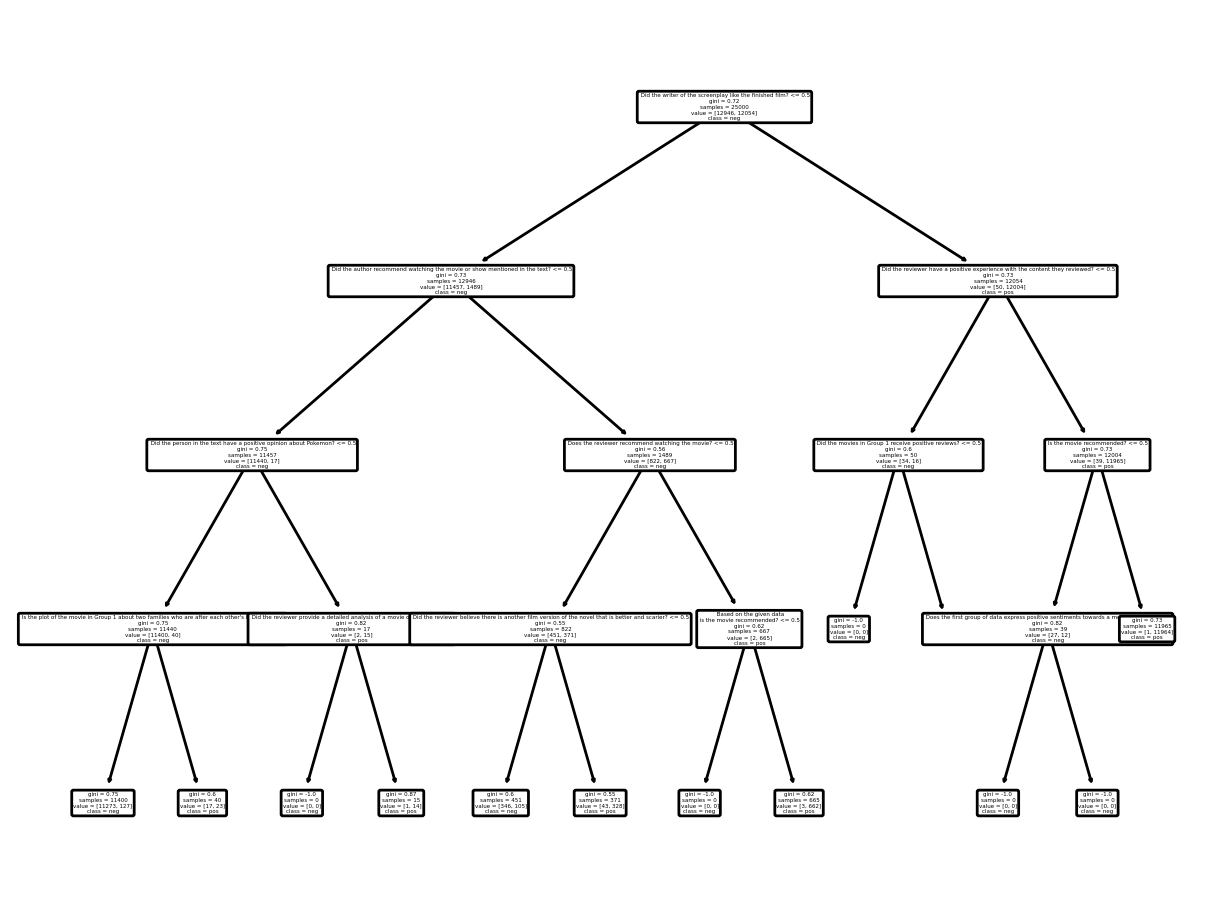

In [16]:
sklearn.tree.plot_tree(dt, feature_names=feat_names, class_names=['neg', 'pos'],
                        precision=2, rounded=True, fontsize=2)
plt.show()